In [72]:
import nltk
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import re
import seaborn as sns
import functools as ft

## Sentences and Vector Models

In [4]:
STOP = set(nltk.corpus.stopwords.words("english"))
#STOP = set("")

class Sentence:
    #text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    #text = re.sub(r"\s{2,}", " ", text)
    
    def __init__(self, sentence, scy):
        self.raw = sentence
        normalized_sentence = sentence.replace("‘", "'").replace("’", "'")
        #self.tokens = scy(normalized_sentence)
        token = scy(normalized_sentence.lower())
        self.tokens = token
        #self.tokens = [t.lower_ for t in token] 
        self.tokens_without_stop = [t.lower_ for t in token if not t.is_stop and not t.is_punct]
        #self.tokens = [t.lower() for t in nltk.word_tokenize(normalized_sentence)]
        #self.tokens_without_stop = [t for t in self.tokens if t not in STOP]

In [78]:
class ModelInterface:
    def vector(self, text: str) -> list:
        """Load vector from model."""
        pass
    
class Word2VecDE(ModelInterface):  
    def __init__(self, model):
        self.model = model
        self.hit = 0
        self.miss = 0
        
    def vector(self, text):
        if str(text).lower() in self.model:  
            self.hit += 1
            return self.model[str(text).lower()]
        else:
            self.miss += 1
            return np.zeros(300)
    
class Word2Vec(ModelInterface):  
    def __init__(self, model):
        self.model = model
        
    def vector(self, text):   
        if str(text).lower() in self.model:  
            return self.model[str(text).lower()]
        else:
            return np.zeros(300)

class FastText(ModelInterface):  
    def __init__(self, model):
        self.model = model
        
    def vector(self, text):
        return self.model.get_word_vector(str(text).lower())
    
class Spacy(ModelInterface):  
    def __init__(self, model):
        self.model = model
        
    def vector(self, text):
        return text.vector
    
class STransformer(ModelInterface):  
    def __init__(self, model):
        self.model = model
        
    def vector(self, text):
        return self.model.encode(text)

## Methods

In [6]:
def run_avg_benchmark(sentences1, sentences2, model=None, use_stoplist=False): 
    sims = []
    for (sent1, sent2) in zip(sentences1, sentences2):
    
        tokens1 = sent1.tokens_without_stop if use_stoplist else sent1.tokens
        tokens2 = sent2.tokens_without_stop if use_stoplist else sent2.tokens
        #print(len(tokens1))
        
        tokens1 = [model.vector(token) for token in tokens1 if np.linalg.norm(model.vector(token)) > 0]
        tokens2 = [model.vector(token) for token in tokens2 if np.linalg.norm(model.vector(token)) > 0]
        #print(len(tokens1))
        
        if len(tokens1) == 0 or len(tokens2) == 0:
            sims.append(0)
            continue
            
        embedding1 = np.average(tokens1, axis=0, weights=None).reshape(1, -1)
        embedding2 = np.average(tokens2, axis=0, weights=None).reshape(1, -1)
        
        sim = cosine_similarity(embedding1, embedding2)[0][0]
        sims.append(sim)

    return sims

In [7]:
from sklearn.decomposition import TruncatedSVD

def remove_first_principal_component(X):
    svd = TruncatedSVD(n_components=1, n_iter=7, random_state=0)
    svd.fit(X)
    pc = svd.components_
    XX = X - X.dot(pc.transpose()) * pc
    return XX


def run_sif_benchmark(sentences1, sentences2, model, use_stoplist=False, freqs={}, a=0.001): 
    total_freq = sum(freqs.values())
    
    embeddings = []
    
    # SIF requires us to first collect all sentence embeddings and then perform 
    # common component analysis.
    for (sent1, sent2) in zip(sentences1, sentences2): 
        
        tokens1 = sent1.tokens_without_stop if use_stoplist else sent1.tokens
        tokens2 = sent2.tokens_without_stop if use_stoplist else sent2.tokens
        
        tokens1 = [model.vector(token) for token in tokens1 if np.linalg.norm(model.vector(token)) > 0]
        tokens2 = [model.vector(token) for token in tokens2 if np.linalg.norm(model.vector(token)) > 0]
        
        #tokens1 = [token for token in tokens1 if token in model]
        #tokens2 = [token for token in tokens2 if token in model]
        
        #weights1 = [a/(a+freqs.get(token,0)/total_freq) for token in tokens1]
        #weights2 = [a/(a+freqs.get(token,0)/total_freq) for token in tokens2]
        
        #embedding1 = np.average([model[token] for token in tokens1], axis=0, weights=weights1)
        #embedding2 = np.average([model[token] for token in tokens2], axis=0, weights=weights2)
        embedding1 = np.average(tokens1, axis=0, weights=None)
        embedding2 = np.average(tokens2, axis=0, weights=None)
        
        embeddings.append(embedding1)
        embeddings.append(embedding2)
        
    embeddings = remove_first_principal_component(np.array(embeddings))
    sims = [cosine_similarity(embeddings[idx*2].reshape(1, -1), 
                              embeddings[idx*2+1].reshape(1, -1))[0][0] 
            for idx in range(int(len(embeddings)/2))]

    return sims

In [8]:
def run_sentence_experiment(sentences1, sentences2, model=None, use_stoplist=False): 
    sims = []
    for (sent1, sent2) in zip(sentences1, sentences2):
        embedding1 = model.vector(sent1.raw).reshape(1, -1)
        embedding2 = model.vector(sent2.raw).reshape(1, -1)
        
        sim = cosine_similarity(embedding1, embedding2)[0][0]
        sims.append(sim)

    return sims

In [9]:
import scipy
def run_experiment(df, benchmarks, scy): 
    
    sentences1 = [Sentence(s, scy) for s in df['sent_1']]
    sentences2 = [Sentence(s, scy) for s in df['sent_2']]
    
    result = []
    for label, method in benchmarks:
        sims = method(sentences1, sentences2)
        #print(label, sims)
        
        if 'sim' in df.columns:
            pearson_correlation = scipy.stats.pearsonr(sims, df['sim'])[0]
            spearman_correlation = scipy.stats.spearmanr(sims, df['sim'])[0]
            print(label, pearson_correlation)
            result.append((label,pearson_correlation,spearman_correlation))
        else:
            print(label, 'Average: ', sum(sims) / len(sims), sims)
             
    return result

## Benchmarks

In [10]:
import glob
import itertools

def loadFiles(path, file):
    filelist = sorted(glob.glob(path+'/'+file))
    data = []
    for file in filelist:
        with open(file, 'r') as file:
            data.append(file.read().replace('\n', ' ').strip())
    return data

def loadGermanParaphraseCorpus(path):
    lowParaphrased = loadFiles('german_paraphrase_corpus', 'Baumkuchen_Ohne_Historie_PB*.txt')
    highParaphrased = loadFiles('german_paraphrase_corpus', 'Baumkuchen_Ohne_Historie_PH*.txt')
    notParaphrased = loadFiles('german_paraphrase_corpus', 'Baumkuchen_WWW_*.txt')
    assert(len(lowParaphrased) == 5)
    assert(len(highParaphrased) == 5)
    assert(len(notParaphrased) == 12)
    
    lowParaphrasedCorpus = pd.DataFrame(itertools.permutations(lowParaphrased, 2), columns=['sent_1','sent_2'])
    highParaphrasedCorpus = pd.DataFrame(itertools.permutations(highParaphrased, 2), columns=['sent_1','sent_2'])
    notParaphrasedCorpus = pd.DataFrame(itertools.permutations(notParaphrased, 2), columns=['sent_1','sent_2'])

    return lowParaphrasedCorpus, highParaphrasedCorpus, notParaphrasedCorpus                                                                                         

In [82]:
lowParaphrasedCorpus, highParaphrasedCorpus, notParaphrasedCorpus = loadGermanParaphraseCorpus('german_paraphrase_corpus')
lowParaphrasedCorpus[:5]

,sent_1,sent_2
0,Der Baumkuchen ist ein schichtweise aufgebaute...,Der Baumkuchen ist ein über offener Flamme geb...
1,Der Baumkuchen ist ein schichtweise aufgebaute...,Der Baumkuchen ist über offener Flamme gebacke...
2,Der Baumkuchen ist ein schichtweise aufgebaute...,Baumkuchen ist eine in Schichten aufgebaute u...
3,Der Baumkuchen ist ein schichtweise aufgebaute...,"Der Baumkuchen ist ein Kuchen, der schichtwei..."
4,Der Baumkuchen ist ein über offener Flamme geb...,Der Baumkuchen ist ein schichtweise aufgebaute...


In [12]:
def load_sts_dataset(filename, sent1, sent2, sim):
    # Loads a subset of the STS dataset into a DataFrame. In particular both
    # sentences and their human rated similarity score.
    sent_pairs = []
    with open(filename, 'r') as f:
        for line in f:
            ts = line.strip().split("\t")
            sent_pairs.append((ts[sent1], ts[sent2], float(ts[sim])))
    return pd.DataFrame(sent_pairs, columns=["sent_1", "sent_2", "sim"])

sts_de_dev = load_sts_dataset("german-STSbenchmark/data/deepl/stsb_de_dev.csv", 1, 2, 0)
sts_de_test = load_sts_dataset("german-STSbenchmark/data/deepl/stsb_de_test.csv", 1, 2, 0)

sts_en_dev = load_sts_dataset("stsbenchmark/sts-dev.csv", 5, 6, 4)
sts_en_test = load_sts_dataset("stsbenchmark/sts-test.csv", 5, 6, 4)

In [13]:
sts_de_dev[:5]

,sent_1,sent_2,sim
0,Ein Mann mit einem Schutzhelm tanzt.,Ein Mann mit einem Schutzhelm tanzt.,5.00
1,Ein kleines Kind reitet auf einem Pferd.,Ein Kind reitet auf einem Pferd.,4.75
2,Ein Mann verfüttert eine Maus an eine Schlange.,Der Mann füttert die Schlange mit einer Maus.,5.00
3,Eine Frau spielt Gitarre.,Ein Mann spielt Gitarre.,2.40
4,Eine Frau spielt Flöte.,Ein Mann spielt eine Flöte.,2.75


## Models

In [14]:
import spacy
scy_de = spacy.load("de_core_news_lg")
scy_en = spacy.load("en_core_web_lg")

In [15]:
import pandas as pd

d = {'sent_1': ["Die ursprünglichen Bewohner des Landes, die Indianer, stellen heute nur noch rund ein Prozent der Bevölkerung.", "Der Baumkuchen ist ein Kuchen, der schichtweise aufgebaut ist  und der über offener Flamme gebacken wird. Im folgenden wird die Geschichte des Baumkuchens erzählt, die Herstellungsmethoden im Laufe der Jahrhunderte verglichen und seine geographische Verbreitung beschrieben.", "Guten morgen heute habe ich gut geschlafen."], 'sent_2': ["Die ursprünglichen Bewohner des Landes, die Indianer, stellen heute nur noch rund ein Prozent der Bevölkerung.", "Im folgenden wird die Geschichte des Baumkuchens erzählt, die Herstellungsmethoden im Laufe der Jahrhunderte verglichen und seine geographische Verbreitung beschrieben. Baumkuchen ist vermutlich das weltweit am besten bekannte Gebäck aus Deutschland und wird wegen seines feinen Geschmacks auf mehreren Kontinenten gerne verzehrt.", 'Das Essen hat sehr gut geschmeckt.']}
testdata = pd.DataFrame(data=d)
testdata

,sent_1,sent_2
0,"Die ursprünglichen Bewohner des Landes, die In...","Die ursprünglichen Bewohner des Landes, die In..."
1,"Der Baumkuchen ist ein Kuchen, der schichtweis...",Im folgenden wird die Geschichte des Baumkuche...
2,Guten morgen heute habe ich gut geschlafen.,Das Essen hat sehr gut geschmeckt.


In [16]:
import gensim
import os
from gensim.models import Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec

PATH_TO_WORD2VEC = os.path.expanduser("word2vec/GoogleNews-vectors-negative300.bin")
word2vec = gensim.models.KeyedVectors.load_word2vec_format(PATH_TO_WORD2VEC, binary=True)

/Users/tobias/web/studium/similarity/myenv/lib/python3.9/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [17]:
import csv
import ast
#word2vec_de = gensim.models.KeyedVectors.load_word2vec_format('word2vec/vectors.txt', fvocab='word2vec/vocab.txt', binary=False)

PATH_TO_WORD2VEC_DE = os.path.expanduser("word2vec/vectors.txt")

with open(PATH_TO_WORD2VEC_DE) as file_in:
    reader = csv.reader(file_in, delimiter=" ")
    word2vec_de = {ast.literal_eval(word).decode(): np.array(vect, dtype=np.float64) for word, *vect in reader}

In [18]:
import fasttext
fasttext = fasttext.load_model('cc.de.300.bin')

In [19]:
from sentence_transformers import SentenceTransformer
mpnet = SentenceTransformer("sentence-transformers/paraphrase-multilingual-mpnet-base-v2")

## Experiments

In [79]:
benchmarks_en = [
    ("AVG-WORD-W2V", ft.partial(run_avg_benchmark, model=Word2Vec(word2vec), use_stoplist=False)),
    ("SIF-WORD-W2V", ft.partial(run_sif_benchmark, model=Word2Vec(word2vec), use_stoplist=False)),
    ("SPACY-WORD", ft.partial(run_avg_benchmark, model=Spacy(scy_en), use_stoplist=False)),
    ("MPNET-SENT", ft.partial(run_sentence_experiment, model=STransformer(mpnet), use_stoplist=False))
]

In [22]:
benchmarks_de = [
    ("AVG-WORD-W2V", ft.partial(run_avg_benchmark, model=Word2VecDE(word2vec_de), use_stoplist=False)),
    ("AVG-WORD-W2V-STOP", ft.partial(run_avg_benchmark, model=Word2VecDE(word2vec_de), use_stoplist=True)),
    ("AVG-WORD-FT", ft.partial(run_avg_benchmark, model=FastText(fasttext), use_stoplist=False)),
    ("AVG-WORD-FT-STOP", ft.partial(run_avg_benchmark, model=FastText(fasttext), use_stoplist=True)),
    ("AVG-SENT-FT", ft.partial(run_sentence_experiment, model=FastText(fasttext), use_stoplist=False)),
    ("SIF-WORD-W2V", ft.partial(run_sif_benchmark, model=Word2VecDE(word2vec_de), use_stoplist=False)),
    #("SIF-WORD-W2V-STOP", ft.partial(run_sif_benchmark, model=Word2VecDE(word2vec_de), use_stoplist=True)),
    ("SIF-WORD-FT", ft.partial(run_sif_benchmark, model=FastText(fasttext), use_stoplist=False)),
    ("SPACY-WORD", ft.partial(run_avg_benchmark, model=Spacy(scy_de), use_stoplist=False)),
    ("MPNET-SENT", ft.partial(run_sentence_experiment, model=STransformer(mpnet), use_stoplist=False))
]

In [80]:
benchmark_results = {}
benchmark_results["STS-DE-TEST"] = run_experiment(sts_de_test, benchmarks_de, scy_de)

AVG-WORD-W2V 0.46925698629470386
AVG-WORD-W2V-STOP 0.34957657112062346
AVG-WORD-FT 0.2537352659363618
AVG-WORD-FT-STOP 0.4095159416493752
AVG-SENT-FT 0.5112796352967722
SIF-WORD-W2V 0.5056840169156406
SIF-WORD-FT 0.3844519834014425
SPACY-WORD 0.25980634792717916
MPNET-SENT 0.8193534938472506


In [81]:
benchmark_results["STS-EN-TEST"] = run_experiment(sts_en_test, benchmarks_en, scy_en)

AVG-WORD-W2V 0.6227166890980458
SIF-WORD-W2V 0.6674557568734617
SPACY-WORD 0.42216729387877655
MPNET-SENT 0.8543448183405837


### Results

In [139]:
def plot_benchmark(data, figsize=(20, 10)):
    benchmark_results_pd = pd.DataFrame(data,columns=['label','pearson_correlation','spearman_correlation'])
    
    sns.set_color_codes("pastel")
    sns.set(font_scale = 1.2)
    f, ax = plt.subplots(figsize=figsize)
    sns.barplot(x="label", y="pearson_correlation", data=benchmark_results_pd)
    ax.set(ylabel="Pearson's correlation", xlabel="")

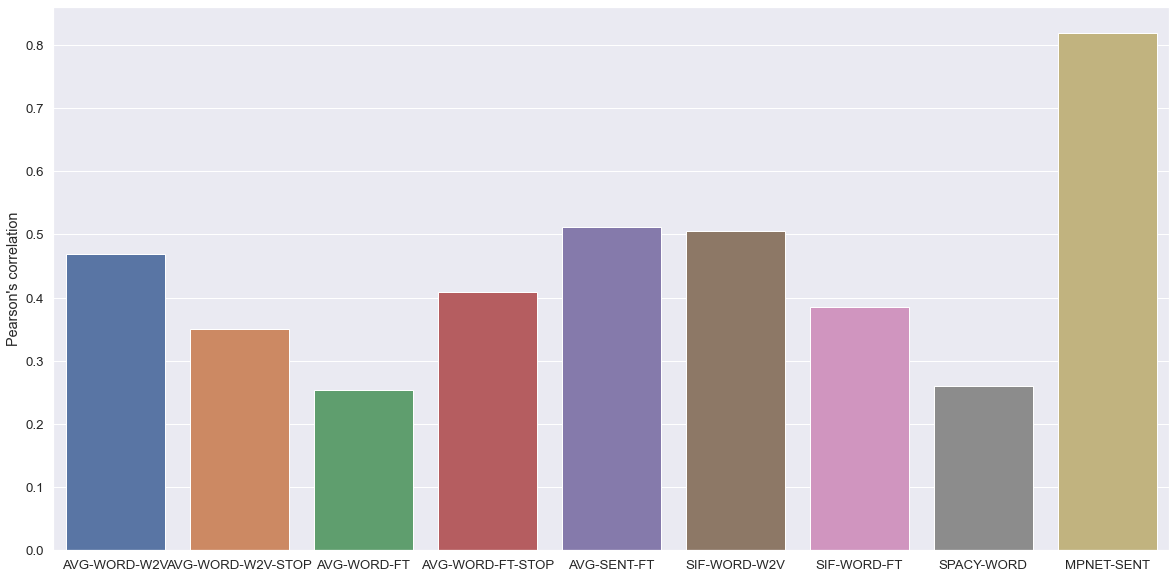

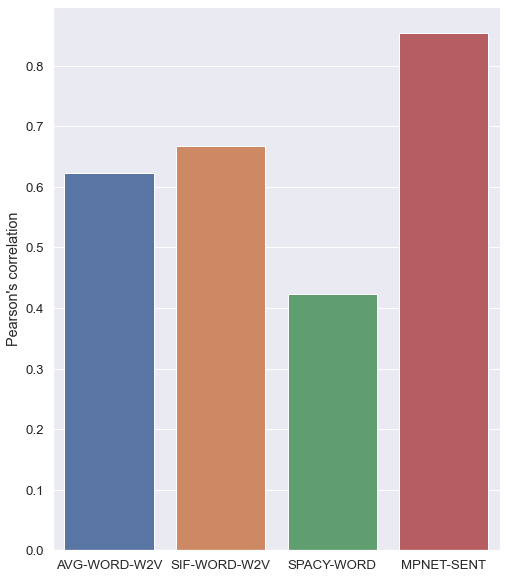

In [140]:
plot_benchmark(benchmark_results["STS-DE-TEST"])
plot_benchmark(benchmark_results["STS-EN-TEST"], (8,10))